# Feature Importance

## Basic Analysis

The features we used to predict the end station region are the following:
* ride type (classic vs electric bike)
* rider type (member vs casual rider)
* start region
* ride start hour of the day
* ride start day of the month
* ride start month of the year
* ride start day of the week
* weather of the day

Of this list, we know that start region had the biggest impact on the model's predictions. We know this partly because of the strong direct correlation we observed between start and end regions during our Data Exploration stage:

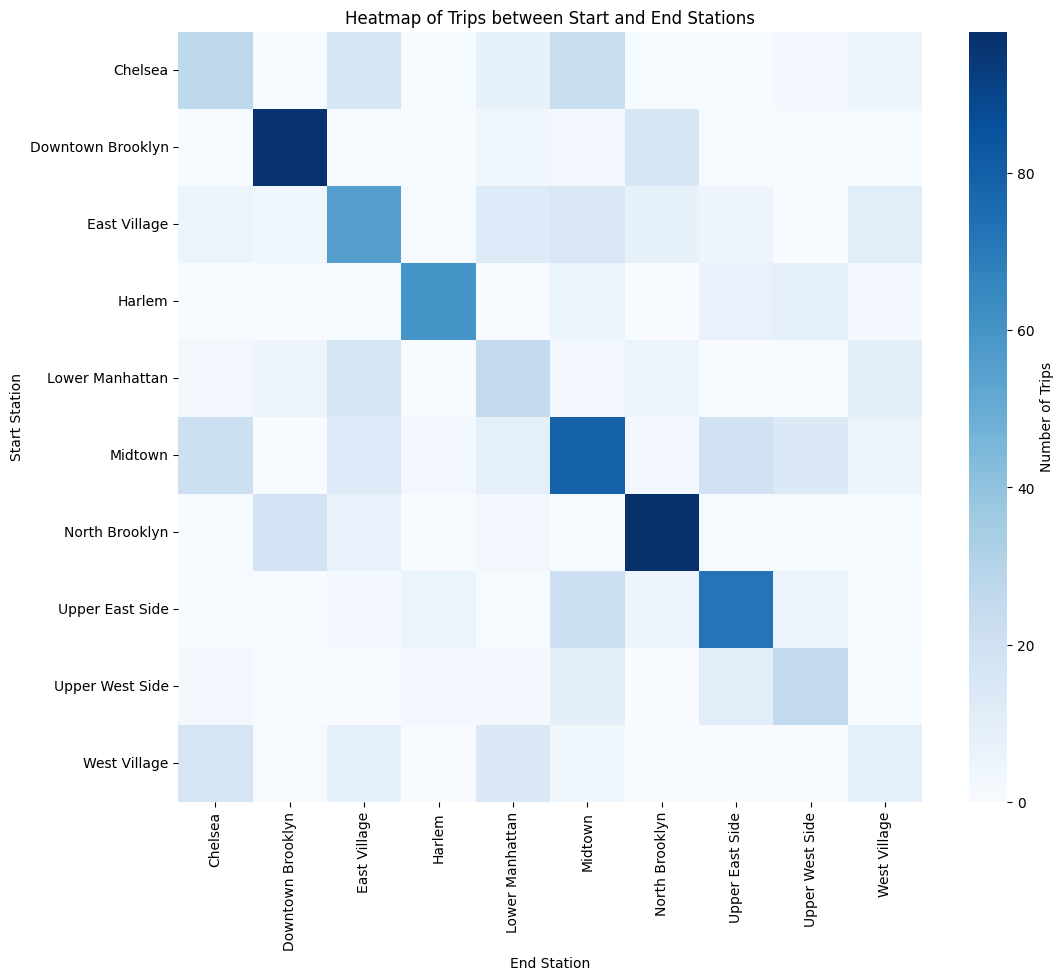

Compared to the start region, we observed little to no discernable relationships between the other features and the end region.

## Shapely Values

We use the SHAP Python library to generate Shapely values for our input features to quantitatively examine feature importance.

### Load data and train model

This is the same model in our Milestone 3 notebook - please refer to that for explanations.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
import math

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if __name__=='__main__':
    print('Using device:', DEVICE)

Using device: cpu


In [ ]:
# NOTE FOR GRADERS - please add the folder linked below to your drive and alter this string to match the location of the "pickled_data" folder:
# https://drive.google.com/drive/folders/1upZ3Oh242b83WTBUQB4HS64M0BlY2PHE?usp=drive_link
shared_folder_path = f'/content/drive/MyDrive/CS547/CS547 Project Group 11/pickled_data'
save_path = f'{shared_folder_path}/debugging_dataset_2023.pkl'

In [ ]:
df = pd.read_pickle(save_path)
df = df.sample(frac=0.5).reset_index(drop=True)
print(df.shape)

(877677, 15)


In [ ]:
# Process Weather Data
weather_df = pd.read_csv(f'{shared_folder_path}/weather_data.csv')
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

weather_df['start_day'] = weather_df['DATE'].dt.day
weather_df['start_month'] = weather_df['DATE'].dt.month
weather_df.drop(columns=['STATION', 'NAME', 'DATE'], inplace=True)
weather_df.head()

,PRCP,SNOW,SNWD,WESD,WESF,start_day,start_month
0,0.40,0.0,0.0,0.0,0.0,1,1
1,0.00,0.0,0.0,0.0,0.0,2,1
2,0.02,0.0,0.0,0.0,0.0,3,1
3,0.37,0.0,0.0,0.0,0.0,4,1
4,0.09,0.0,0.0,0.0,0.0,5,1


In [ ]:
# Region coordinates derived from ChatGPT

REGION_MAPPING = {
    "Lower Manhattan": 0,
    "Midtown": 1,
    "Upper East Side": 2,
    "Upper West Side": 3,
    "East Village": 4,
    "West Village": 5,
    "Chelsea": 6,
    "Harlem": 7,
    "Downtown Brooklyn": 8,
    "North Brooklyn": 9
}
REGION_LOCS = {
    0: (40.7128, -74.0060),
    1: (40.7549, -73.9840),
    2: (40.7736, -73.9566),
    3: (40.7870, -73.9754),
    4: (40.7264, -73.9818),
    5: (40.7347, -74.0049),
    6: (40.7430, -74.0018),
    7: (40.8116, -73.9465),
    8: (40.6958, -73.9936),
    9: (40.7081, -73.9571)
}

In [ ]:
import numpy as np

# Convert REGION_LOCS to a NumPy array for efficient computation
region_ids = np.array(list(REGION_LOCS.keys()))
region_coords = np.array(list(REGION_LOCS.values()))

def vectorized_haversine(lat, lon, region_coords):
    """Vectorized calculation of haversine distance between points and regions."""
    R = 6371  # Earth's radius in km

    # Convert degrees to radians
    lat1, lon1 = np.radians(lat), np.radians(lon)
    region_lat, region_lon = np.radians(region_coords[:, 0]), np.radians(region_coords[:, 1])

    # Calculate haversine formula
    dlat = region_lat[:, None] - lat1
    dlon = region_lon[:, None] - lon1
    a = np.sin(dlat / 2)**2 + np.cos(region_lat[:, None]) * np.cos(lat1) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # Distance in kilometers

# Vectorized function to find nearest region
def find_nearest_regions(latitudes, longitudes, region_coords, region_ids):
    distances = vectorized_haversine(latitudes, longitudes, region_coords)
    nearest_indices = np.argmin(distances, axis=0)
    return region_ids[nearest_indices]

# Apply the vectorized function to the DataFrame
df['start_region'] = find_nearest_regions(df['start_lat'].values, df['start_lng'].values, region_coords, region_ids)
df['end_region'] = find_nearest_regions(df['end_lat'].values, df['end_lng'].values, region_coords, region_ids)

In [ ]:
# Encode 'rideable_type' and store the mapping
df['rideable_type'], rideable_type_mapping = pd.factorize(df['rideable_type'])
rideable_type_mapping = dict(enumerate(rideable_type_mapping))

In [ ]:
# Encode 'member_casual' and store the mapping
df['member_casual'], member_casual_mapping = pd.factorize(df['member_casual'])
member_casual_mapping = dict(enumerate(member_casual_mapping))

In [ ]:
# Encoding 'started_at' time into different types
df['start_hour'] = df['started_at'].dt.hour
df['start_day'] = df['started_at'].dt.day
df['start_month'] = df['started_at'].dt.month
df['start_weekday'] = df['started_at'].dt.weekday

In [ ]:
# Add weather data
df = df.merge(weather_df, left_on=['start_day', 'start_month'], right_on=['start_day', 'start_month'], how='left')

In [ ]:
# Haversine distance calculation derived from ChatGPT

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Calculate the great circle distance between two points on the earth."""
    R = 6371  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

In [ ]:
# Create Edges for GNN graph
edges = []
for region_name, (region_lat, region_lon) in REGION_LOCS.items():
    for other_region_name, (other_region_lat, other_region_lon) in REGION_LOCS.items():
        distance = haversine_distance(region_lat, region_lon, other_region_lat, other_region_lon)
        edges.append((region_name, other_region_name, distance))

In [ ]:
edges_df = pd.DataFrame(edges, columns=['Region 1', 'Region 2', 'Distance'])
edges_df.head()

,Region 1,Region 2,Distance
0,0,0,0.000000
1,0,1,5.034951
2,0,2,7.938928
3,0,3,8.643947
4,0,4,2.538970


In [ ]:
df.drop(columns=['ride_id', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'], inplace=True)

# We exclusively use regions instead of lat/lng for more straightforward relationships between features and label
df.drop(columns=['start_lat', 'start_lng', 'end_lat', 'end_lng'], inplace=True)
df.dropna(inplace=True)
df.head()

,rideable_type,member_casual,start_region,end_region,start_hour,start_day,start_month,start_weekday,PRCP,SNOW,SNWD,WESD,WESF
0,0,0,7,7,7,15,7,5,0.76,0.0,0.0,0.0,0.0
1,1,1,1,1,23,2,9,5,0.00,0.0,0.0,0.0,0.0
2,0,0,9,9,8,20,9,2,0.00,0.0,0.0,0.0,0.0
3,1,0,4,4,12,19,11,6,0.00,0.0,0.0,0.0,0.0
4,1,0,7,7,20,10,5,2,0.00,0.0,0.0,0.0,0.0


In [ ]:
# Verify the new encoding
num_classes = len(df['end_region'].unique())
print(f"Number of classes after encoding: {num_classes}")
print(f"Maximum class index after encoding: {df['end_region'].max()}")

Number of classes after encoding: 10
Maximum class index after encoding: 9


In [ ]:
# Separate features and target
features = df.drop(columns=['end_region'])
labels = df['end_region']
del df # Deleting unnecessary objects to save RAM

In [ ]:
# Split training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

type(X_test)

pandas.core.frame.DataFrame

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32, device=DEVICE)
X_test = torch.tensor(X_test.values, dtype=torch.float32, device=DEVICE)
y_train = torch.tensor(y_train.values, dtype=torch.long, device=DEVICE)
y_test = torch.tensor(y_test.values, dtype=torch.long, device=DEVICE)

In [ ]:
type(X_test)

torch.Tensor

In [ ]:
# Edges for Graph
edge_index = torch.tensor(edges_df[['Region 1', 'Region 2']].values, dtype=torch.long, device=DEVICE).t().contiguous()
edge_weights = torch.tensor(edges_df['Distance'].values, dtype=torch.float32, device=DEVICE)
edge_weights.shape

torch.Size([100])

In [ ]:
# Nodes for graph
node_features = []
for key in range(10):
  (r1, r2) = REGION_LOCS[key]
  node_features.append([key, r1, r2]) # (label, latitude, longitude)

node_features = torch.tensor(node_features, dtype=torch.float32, device=DEVICE)
node_features.shape

torch.Size([10, 3])

In [ ]:
# Create a list of Data objects for each batch of trips
batch_size = 8192
batched_data = []

# Chunk trips and labels into batches
num_batches = len(X_train) // batch_size + (1 if len(X_train) % batch_size > 0 else 0)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_train))

    # Create a Data object for this batch
    batch_trips = X_train[start_idx:end_idx]
    batch_labels = y_train[start_idx:end_idx]
    batch_data = Data(nodes=node_features,
                      trips=batch_trips,
                      edge_index=edge_index,
                      edge_attr=edge_weights,
                      labels=batch_labels)
    batched_data.append(batch_data)

# Create a DataLoader to manage the batched data
dataloader = DataLoader(batched_data, batch_size=1, shuffle=True)

In [ ]:
class HybridGCNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_trip_features, num_nodes):
        super(HybridGCNModel, self).__init__()
        # GCN Layers
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 16)

        # MLP Layers for the trip features
        self.fc1 = torch.nn.Linear(num_trip_features, 128)
        self.fc2 = nn.Linear(128, 32) # Align dimensions with GCN output

        # Final classifier layers
        self.fc3 = torch.nn.Linear(48, 32)
        self.fc4 = torch.nn.Linear(32, num_nodes)

    def forward(self, data):
        x, edge_index, edge_weights, t = data.nodes, data.edge_index, data.edge_attr, data.trips

        # GCN part: Graph-based learning
        gnn_out = F.relu(self.conv1(x, edge_index=edge_index, edge_weight=edge_weights))
        gnn_out = self.conv2(gnn_out, edge_index=edge_index, edge_weight=edge_weights)

        # apply graph to trip based on start station
        start_station_embeddings = gnn_out[t[:, 2].long()]

        # MLP part: Learning from trip features
        mlp_out = F.relu(self.fc1(t))
        mlp_out = self.fc2(mlp_out)  # Align with GCN output dimension

        # Combine GCN and MLP outputs (concatenation)
        combined_out = torch.cat([start_station_embeddings, mlp_out], dim=1)

        # Final classification
        out = F.relu(self.fc3(combined_out))
        out = self.fc4(out)
        output = F.log_softmax(out, dim=1)

        return output

In [ ]:
# Model Initialization
num_node_features = 3  # Number of node features
num_trip_features = 12  # Number of trip features
num_nodes = 10  # Number of nodes in the graph

model = HybridGCNModel(num_node_features, num_trip_features, num_nodes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(DEVICE)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    tot_loss = 0.0
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
      batch = batch.to(DEVICE)

      out = model(batch)  # Forward pass (graph-based and feature-based)
      loss = criterion(out, batch.labels)  # Compute loss
      loss.backward()  # Backpropagate

      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
      optimizer.step()  # Update weights
      optimizer.zero_grad()

      tot_loss += loss.item()

    loss = tot_loss / len(dataloader)
    if epoch % 10 == 0: print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

print(f'Final Loss: {loss:.4f}')

Epoch [1/50], Loss: 1.8201
Epoch [11/50], Loss: 1.4342
Epoch [21/50], Loss: 1.4069
Epoch [31/50], Loss: 1.3931
Epoch [41/50], Loss: 1.3855
Final Loss: 1.3861


In [ ]:
# Evaluation (on test set)
model.eval()
test_data = Data(nodes=node_features,
            trips=X_test,
            edge_index=edge_index,
            edge_attr=edge_weights,
            labels=y_test)
with torch.no_grad():
    out = model(test_data)  # Forward pass on test set
    _, pred = torch.max(out, dim=1)  # Get the predicted classes
    accuracy = (pred == y_test).sum().item() / len(y_test)
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.5535


### Examine Shapely Values

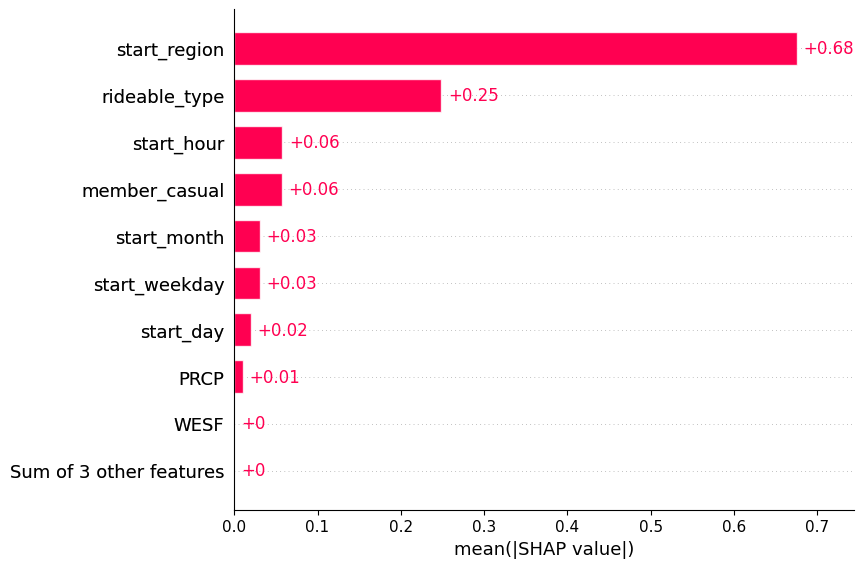

In [ ]:
import shap

shap.initjs()

def model_predict(data):
    model.eval()
    with torch.no_grad():
        data_obj = Data(nodes=node_features,
            trips=torch.tensor(data.values, dtype=torch.float32, device=DEVICE),
            edge_index=edge_index,
            edge_attr=edge_weights)
        return model(data_obj).numpy()

shap_test_features = features[:100]

explainer = shap.explainers.Exact(model_predict, shap_test_features)
shap_values = explainer(shap_test_features)

shap_values_mean = np.mean(shap_values.values, axis=2)
mean_explanation = shap.Explanation(values=shap_values_mean,
                                    base_values=shap_values.base_values.mean(axis=1),
                                    data=shap_values.data,
                                    feature_names=shap_values.feature_names)
shap.plots.bar(mean_explanation)

You can see that, when examining the Shapely values of each feature over all the end regions, the start_region has by far the greatest value, as expected. The next most impactful input feature is the rideable type.